# Analyzing bike usage by time of day and day of week


For anyone managing a bike share system, understanding the patterns of bike use is pretty important. Capacity planning, in terms of the number of bikes needed, can be aided by analysis of the number of bikes in use by time of day and day of week. In this notebook, I show how the package [hillmaker](https://github.com/misken/hillmaker) can be used to create statistical plots of bike use. Hillmaker was originally developed for use in healthcare capacity planning problems but can be used for any service system in which start times and stop times are available. This cycle share dataset is ideal.

In this first example we'll compare bike use patterns by members vs. short-term pass holders. Our goal is to compute the mean and percentiles of the number of bikes in use by hour of day and day of week. 

### Module imports
To run Hillmaker we only need to import a few modules. Since the main Hillmaker function uses Pandas DataFrames for both data input and output, we need to import `pandas` in addition to `hillmaker`.

In [21]:
import pandas as pd
import hillmaker as hm

We'll use matplotlib for the plotting. There's some trickiness involved in x-axis formatting that can be solved with a `DateFormatter`.

In [22]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

In [23]:
%matplotlib inline

### Read trip data file

Read the trip data from a csv file into a DataFrame and tell Pandas which fields to treat as dates.

In [24]:
file_trip_data = './cycle-share-dataset/trip.csv'

In [25]:
trip_df_raw = pd.read_csv(file_trip_data, parse_dates=['starttime','stoptime'], error_bad_lines=False)
trip_df_raw.info() # Check out the structure of the resulting DataFrame

b'Skipping line 50794: expected 12 fields, saw 20\n'


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286857 entries, 0 to 286856
Data columns (total 12 columns):
trip_id              286857 non-null int64
starttime            286857 non-null datetime64[ns]
stoptime             286857 non-null datetime64[ns]
bikeid               286857 non-null object
tripduration         286857 non-null float64
from_station_name    286857 non-null object
to_station_name      286857 non-null object
from_station_id      286857 non-null object
to_station_id        286857 non-null object
usertype             286857 non-null object
gender               181557 non-null object
birthyear            181553 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(1), object(7)
memory usage: 26.3+ MB


There are some duplicate rows in this dataset. Let's get rid of them.

In [26]:
trip_df = trip_df_raw.drop_duplicates()

In [27]:
trip_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 236065 entries, 0 to 286856
Data columns (total 12 columns):
trip_id              236065 non-null int64
starttime            236065 non-null datetime64[ns]
stoptime             236065 non-null datetime64[ns]
bikeid               236065 non-null object
tripduration         236065 non-null float64
from_station_name    236065 non-null object
to_station_name      236065 non-null object
from_station_id      236065 non-null object
to_station_id        236065 non-null object
usertype             236065 non-null object
gender               146171 non-null object
birthyear            146167 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(1), object(7)
memory usage: 23.4+ MB


In [28]:
trip_df.head(3)

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,gender,birthyear
0,431,2014-10-13 10:31:00,2014-10-13 10:48:00,SEA00298,985.935,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1960.0
1,432,2014-10-13 10:32:00,2014-10-13 10:48:00,SEA00195,926.375,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1970.0
2,433,2014-10-13 10:33:00,2014-10-13 10:48:00,SEA00486,883.831,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Female,1988.0


In [29]:
trip_df.tail(5)

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,gender,birthyear
286852,255241,2016-08-31 23:34:00,2016-08-31 23:45:00,SEA00201,679.532,Harvard Ave & E Pine St,2nd Ave & Spring St,CH-09,CBD-06,Short-Term Pass Holder,NaN,NaN
286853,255242,2016-08-31 23:48:00,2016-09-01 00:20:00,SEA00247,1965.418,Cal Anderson Park / 11th Ave & Pine St,6th Ave S & S King St,CH-08,ID-04,Short-Term Pass Holder,NaN,NaN
286854,255243,2016-08-31 23:47:00,2016-09-01 00:20:00,SEA00300,1951.173,Cal Anderson Park / 11th Ave & Pine St,6th Ave S & S King St,CH-08,ID-04,Short-Term Pass Holder,NaN,NaN
286855,255244,2016-08-31 23:49:00,2016-09-01 00:20:00,SEA00047,1883.299,Cal Anderson Park / 11th Ave & Pine St,6th Ave S & S King St,CH-08,ID-04,Short-Term Pass Holder,NaN,NaN
286856,255245,2016-08-31 23:49:00,2016-09-01 00:20:00,SEA00442,1896.031,Cal Anderson Park / 11th Ave & Pine St,6th Ave S & S King St,CH-08,ID-04,Short-Term Pass Holder,NaN,NaN


### Overall ride counts by user type
Let's create a simple function to summarize factor variables such as `usertype`.

In [30]:
def factorsummary(series):
    print(series.name)
    x_null = series.isnull().sum()
    x_notnull = series.count()
    x_tot = x_notnull + x_null
    print("total\t{}".format(x_tot))
    print("nonnull\t{}".format(x_notnull))
    print("null\t{}\n".format(x_null))
    print(series.value_counts())
    

In [31]:
factorsummary(trip_df['usertype'])

usertype
total	236065
nonnull	236065
null	0

Member                    146171
Short-Term Pass Holder     89894
Name: usertype, dtype: int64


### Creating occupancy summaries
The primary function in `hillmaker` is called `make_hills`. Let's get a little help on this function.

In [32]:
help(hm.make_hills)

Help on function make_hills in module hillmaker.hills:

make_hills(scenario_name, stops_df, infield, outfield, start_analysis, end_analysis, catfield='', total_str='Total', bin_size_minutes=60, cat_to_exclude=None, totals=True, export_csv=True, export_path='.', return_dataframes=False, verbose=0)
    Compute occupancy, arrival, and departure statistics by time bin of day and day of week.
    
    Main function that first calls `bydatetime.make_bydatetime` to calculate occupancy, arrival
    and departure values by date by time bin and then calls `summarize.summarize_bydatetime`
    to compute the summary statistics.
    
    Parameters
    ----------
    scenario_name : string
        Used in output filenames
    stops_df : DataFrame
        Base data containing one row per visit
    infield : string
        Column name corresponding to the arrival times
    outfield : string
        Column name corresponding to the departure times
    start_analysis : datetime-like, str
        Starti

You can read more about Hillmaker at [http://hselab.org/hillmaker-python-released.html](http://hselab.org/hillmaker-python-released.html). It's free and open source.

#### Specify values for all the required inputs:


In [33]:
# Required inputs
# ---------------

# scenario name
scenario = 'bikeshare_1'

# Column name in trip_df corresponding to the bike rental time
in_fld_name = 'starttime'

# Column name in trip_df corresponding to the bike return time
out_fld_name = 'stoptime'

# Column name in trip_df corresponding to some categorical field for grouping
cat_fld_name = 'usertype'

# Start and end times for the analysis. We'll just use data from 2015.
start = '1/1/2015'
end = '12/31/2015 23:45'

# Optional inputs
# ---------------

# Verbosity level of hillmaker messages
verbose = 1

# Path to destination location for csv output files produced by hillmaker
output = './output'


Now we'll call the main `make_hills` function. 

In [34]:
hills_1 = hm.make_hills(scenario, trip_df, in_fld_name, out_fld_name, start, end, cat_fld_name, 
              export_path = output, verbose=verbose, return_dataframes=True)

min of intime: 2014-10-13 10:31:00
max of outtime: 2016-09-01 00:20:00
Datetime DataFrame created (seconds): 54.1223
Summaries by datetime created (seconds): 5.1214
Summaries by category created (seconds): 0.0638
Summaries exported to csv (seconds): 0.3367
Total time (seconds): 59.6452


In [35]:
hills_1.keys()

dict_keys(['bydatetime', 'occupancy', 'tot_arr', 'arrivals', 'tot_occ', 'tot_dep', 'departures'])

We are primarily interested in the occupancy (i.e. number of bikes in use) DataFrame contained in the `hills_1` dictionary returned by `make_hills`. You can also go to the specified output folder to see a csv export of all of the returned DataFrames.

In [36]:
occ_df = hills_1['occupancy']
occ_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 504 entries, (Member, 0, 0) to (Total, 6, 23)
Data columns (total 22 columns):
count    504 non-null float64
cv       504 non-null float64
kurt     504 non-null float64
max      504 non-null float64
mean     504 non-null float64
min      504 non-null float64
p50      504 non-null float64
p55      504 non-null float64
p60      504 non-null float64
p65      504 non-null float64
p70      504 non-null float64
p75      504 non-null float64
p80      504 non-null float64
p85      504 non-null float64
p90      504 non-null float64
p95      504 non-null float64
p975     504 non-null float64
p99      504 non-null float64
sem      504 non-null float64
skew     504 non-null float64
stdev    504 non-null float64
var      504 non-null float64
dtypes: float64(22)
memory usage: 88.7+ KB


In [37]:
occ_df.head()

count        cv       kurt       max  \
category day_of_week bin_of_day                                         
Member   0           0            52.0  1.256350   2.952512  0.633333   
                     1            52.0  2.346570  23.421822  1.000000   
                     2            52.0  3.252450  22.068901  1.000000   
                     3            52.0  4.538608  43.892029  1.000000   
                     4            52.0  1.363325  13.031082  1.400000   

                                     mean  min       p50   p55       p60  \
category day_of_week bin_of_day                                            
Member   0           0           0.117308  0.0  0.083333  0.10  0.100000   
                     1           0.067949  0.0  0.000000  0.00  0.010000   
                     2           0.051282  0.0  0.000000  0.00  0.000000   
                     3           0.031410  0.0  0.000000  0.00  0.000000   
                     4           0.178205  0.0  0.141667  0.15  0.176667   

                                      p65    ...          p80       p85  \
category day_of_week bin_of_day              ...                          
Member   0           0           0.166667    ...     0.216667  0.266667   
                     1           0.035833    ...     0.083333  0.133333   
                     2           0.000000    ...     0.043333  0.050000   
                     3           0.000000    ...     0.000000  0.000000   
                     4           0.183333    ...     0.216667  0.273333   

                                      p90       p95      p975       p99  \
category day_of_week bin_of_day                                           
Member   0           0           0.281667  0.340833  0.519167  0.607833   
                     1           0.150000  0.287500  0.405833  0.711000   
                     2           0.096667  0.318333  0.495417  0.745000   
                     3           0.050000  0.124167  0.193750  0.600500   
                     4           0.376667  0.526667  0.817500  1.145000   

                                      sem      skew     stdev       var  
category day_of_week bin_of_day                                          
Member   0           0           0.020438  1.574965  0.147379  0.021721  
                     1           0.022111  4.413523  0.159446  0.025423  
                     2           0.023130  4.492202  0.166792  0.027820  
                     3           0.019769  6.443027  0.142559  0.020323  
                     4           0.033691  3.168517  0.242952  0.059025  

[5 rows x 22 columns]

In [38]:
occ_df.ix[100:115]

count        cv      kurt        max  \
category day_of_week bin_of_day                                         
Member   4           4            52.0  0.918400  1.242790   0.683333   
                     5            52.0  0.954730  1.864193   1.116667   
                     6            52.0  0.507788 -0.416528   1.433333   
                     7            52.0  0.403850  0.160548   5.466667   
                     8            52.0  0.374097  0.302192   9.116667   
                     9            52.0  0.398853  2.776558  10.583333   
                     10           52.0  0.442266  6.119914   6.900000   
                     11           52.0  0.468916  0.657925   4.966667   
                     12           52.0  0.488284 -0.085686   5.233333   
                     13           52.0  0.477458 -0.539874   4.283333   
                     14           52.0  0.530405  0.699043   4.383333   
                     15           52.0  0.483785 -0.274154   5.000000   
                     16           52.0  0.413111 -0.327665   7.100000   
                     17           52.0  0.398125  0.313277   9.550000   
                     18           52.0  0.489868  1.894254   9.450000   

                                     mean       min       p50       p55  \
category day_of_week bin_of_day                                           
Member   4           4           0.191026  0.000000  0.183333  0.200000   
                     5           0.253526  0.000000  0.191667  0.234167   
                     6           0.702244  0.000000  0.716667  0.766667   
                     7           2.937179  0.000000  2.900000  3.035000   
                     8           5.271795  0.083333  5.358333  5.566667   
                     9           4.341667  0.500000  4.450000  4.666667   
                     10          2.369551  0.350000  2.391667  2.550000   
                     11          2.119551  0.233333  2.000000  2.117500   
                     12          2.286859  0.200000  2.166667  2.300833   
                     13          2.099359  0.216667  1.991667  2.085000   
                     14          1.640705  0.000000  1.583333  1.821667   
                     15          2.292628  0.200000  2.250000  2.468333   
                     16          3.662821  0.000000  3.600000  3.702500   
                     17          5.118269  0.000000  4.650000  4.976667   
                     18          3.602885  0.000000  3.483333  3.617500   

                                      p60       p65    ...          p80  \
category day_of_week bin_of_day                        ...                
Member   4           4           0.216667  0.216667    ...     0.306667   
                     5           0.280000  0.350000    ...     0.433333   
                     6           0.776667  0.835833    ...     0.980000   
                     7           3.273333  3.440833    ...     3.866667   
                     8           5.666667  5.931667    ...     7.130000   
                     9           4.713333  4.860000    ...     5.370000   
                     10          2.576667  2.612500    ...     2.850000   
                     11          2.286667  2.385833    ...     2.826667   
                     12          2.353333  2.460000    ...     3.183333   
                     13          2.156667  2.290833    ...     2.983333   
                     14          1.960000  1.983333    ...     2.333333   
                     15          2.543333  2.757500    ...     3.213333   
                     16          4.030000  4.126667    ...     5.056667   
                     17          5.313333  5.594167    ...     6.600000   
                     18          3.796667  4.018333    ...     4.563333   

                                      p85       p90       p95      p975  \
category day_of_week bin_of_day                                           
Member   4           4           0.316667  0.396667  0.567500  0.662083   
              

In [39]:
occ_df.tail()

count        cv      kurt        max  \
category day_of_week bin_of_day                                         
Total    6           19           52.0  0.963896  0.457969  24.983333   
                     20           52.0  1.216784  7.482720  31.116667   
                     21           52.0  1.112347  6.146433  19.750000   
                     22           52.0  1.151084  2.719110   9.966667   
                     23           52.0  1.275248  1.140526   6.050000   

                                     mean  min       p50       p55       p60  \
category day_of_week bin_of_day                                                
Total    6           19          6.368269  0.0  4.308333  4.919167  5.853333   
                     20          4.755128  0.0  3.075000  4.120000  4.576667   
                     21          3.361538  0.0  2.266667  2.867500  3.080000   
                     22          2.026923  0.0  1.133333  1.398333  2.093333   
                     23          1.341987  0.0  0.650000  0.713333  1.026667   

                                      p65    ...            p80        p85  \
category day_of_week bin_of_day              ...                             
Total    6           19          6.514167    ...      11.626667  14.029167   
                     20          4.850833    ...       8.203333   9.958333   
                     21          3.883333    ...       5.690000   6.696667   
                     22          2.583333    ...       3.173333   3.779167   
                     23          1.269167    ...       2.393333   3.326667   

                                       p90        p95       p975        p99  \
category day_of_week bin_of_day                                               
Total    6           19          16.323333  17.733333  18.470417  21.804333   
                     20          11.983333  14.536667  16.532500  23.823667   
                     21           8.053333   9.410833  10.992500  15.559500   
                     22           4.240000   7.165833   8.354167   9.354667   
                     23           4.296667   5.316667   5.645000   5.871500   

                                      sem      skew     stdev        var  
category day_of_week bin_of_day                                           
Total    6           19          0.851236  1.090686  6.138352  37.679360  
                     20          0.802369  2.300579  5.785966  33.477402  
                     21          0.518533  2.048583  3.739196  13.981585  
                     22          0.323551  1.645069  2.333159   5.443629  
                     23          0.237324  1.475156  1.711366   2.928774  

[5 rows x 22 columns]

The `occ_df` DataFrame has a multi-index with three levels.

In [40]:
occ_df.index

MultiIndex(levels=[['Member', 'Short-Term Pass Holder', 'Total'], [0, 1, 2, 3, 4, 5, 6], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]],
           labels=[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [41]:
occ_df.index.names

FrozenList(['category', 'day_of_week', 'bin_of_day'])

In addition to computing TOD-DOW statistics for both user types (Members and Short-Term Pass Holders), `hillmaker` also computes these statistics for all users.

In [42]:
total_df = occ_df.loc['Total']

In [43]:
total_df.head()

count        cv       kurt       max      mean  min  \
day_of_week bin_of_day                                                        
0           0            52.0  1.354081   2.580376  4.200000  0.740064  0.0   
            1            52.0  2.060242   8.300503  4.250000  0.444551  0.0   
            2            52.0  1.963172  17.575786  4.333333  0.367949  0.0   
            3            52.0  2.604130  13.952304  5.333333  0.390385  0.0   
            4            52.0  1.339915   6.316301  2.150000  0.318590  0.0   

                             p50     p55       p60       p65    ...     \
day_of_week bin_of_day                                          ...      
0           0           0.283333  0.3400  0.556667  0.635833    ...      
            1           0.066667  0.0850  0.133333  0.162500    ...      
            2           0.050000  0.0675  0.136667  0.238333    ...      
            3           0.000000  0.0000  0.000000  0.000000    ...      
            4           0.183333  0.2000  0.210000  0.233333    ...      

                             p80       p85       p90       p95      p975  \
day_of_week bin_of_day                                                     
0           0           1.263333  1.950000  2.000000  3.022500  3.257500   
            1           0.446667  1.023333  1.338333  2.450833  3.467917   
            2           0.556667  0.772500  1.096667  1.513333  1.719167   
            3           0.200000  0.989167  1.000000  1.909167  3.642083   
            4           0.456667  0.600000  0.978333  1.135833  1.345000   

                             p99       sem      skew     stdev       var  
day_of_week bin_of_day                                                    
0           0           3.724000  0.138967  1.745834  1.002107  1.004219  
            1           3.961000  0.127010  2.871952  0.915883  0.838842  
            2           3.032833  0.100171  3.691306  0.722347  0.521785  
            3           4.772333  0.140979  3.591655  1.016612  1.033501  
            4           1.767500  0.059198  2.343557  0.426883  0.182229  

[5 rows x 22 columns]

## The bike use plots
Four different plots are created using `matplotlib` to explore time of day and day of week patterns in bike users by different user types.

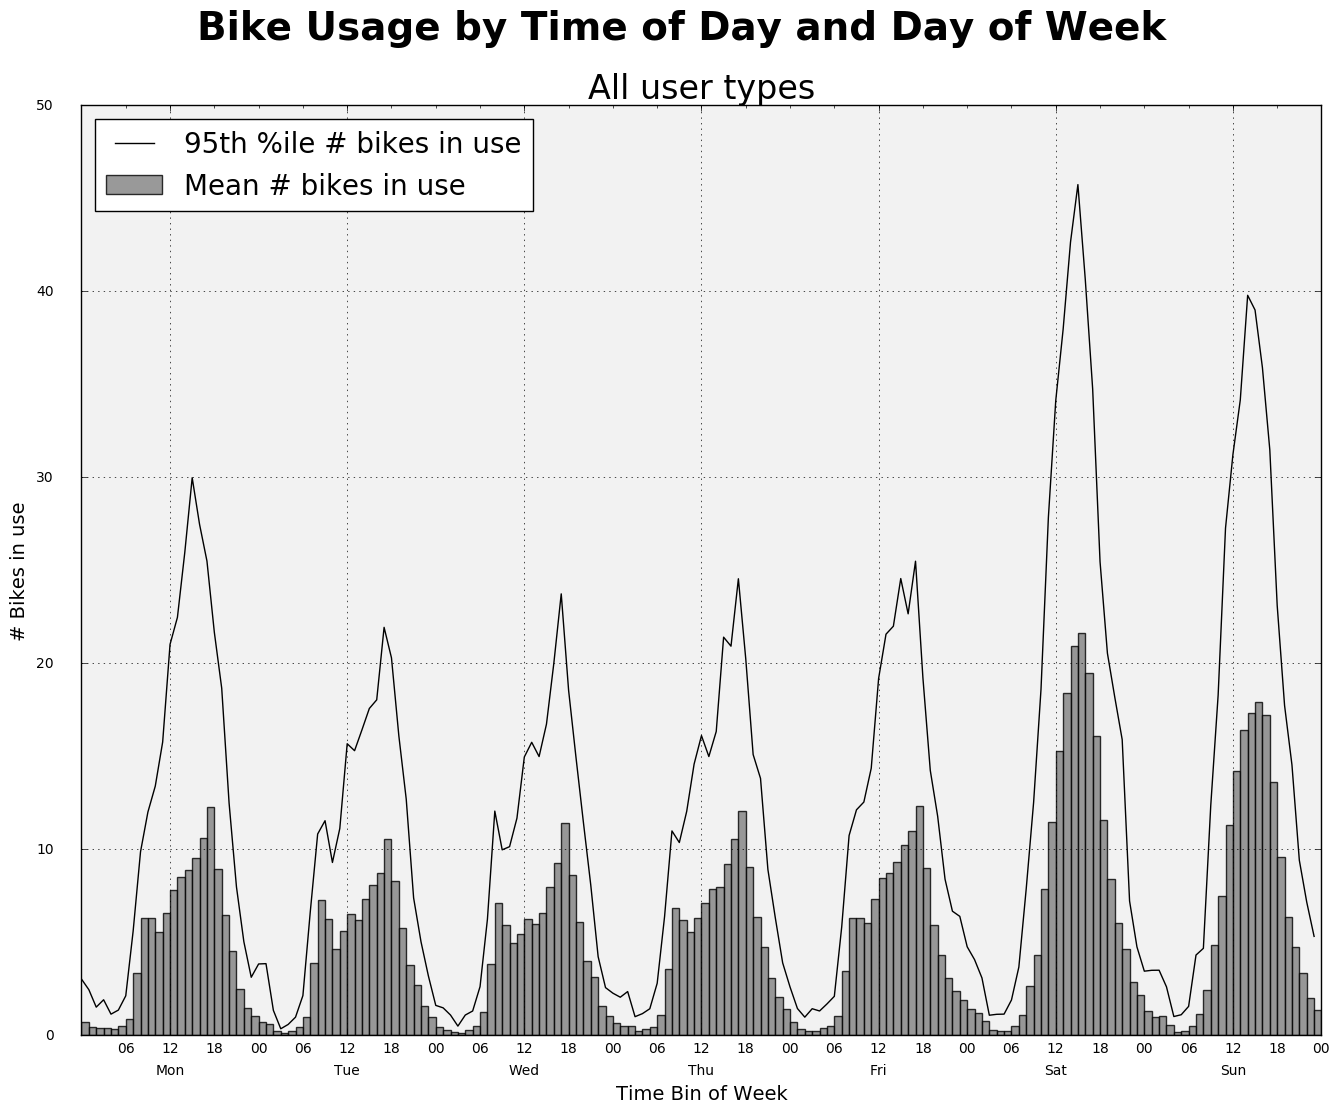

In [44]:
# Create a Figure and Axes object
#--------------------------------

fig1 = plt.figure()
ax1 = fig1.add_subplot(1,1,1)

# Create a list to use as the X-axis values
#-------------------------------------------

timestamps = pd.date_range('01/05/2015', periods=168, freq='60Min').tolist()

major_tick_locations = pd.date_range('01/05/2015 12:00:00', periods=7, freq='24H').tolist()
minor_tick_locations = pd.date_range('01/05/2015 06:00:00', periods=28, freq='6H').tolist()

# Specify the mean occupancy and percentile values
#-----------------------------------------------------------
mean_occ = total_df['mean']
pctile_occ = total_df['p95']

# Styling of bars, lines, plot area
#-----------------------------------

# Style the bars for mean occupancy
bar_color = 'grey'
bar_opacity = 0.8

# Style the line for the occupancy percentile
pctile_line_style = '-'
pctile_color = 'black'
pctile_line_width = 1

# Set the background color of the plot. Argument is a string float in
# (0,1) representing greyscale (0=black, 1=white)
ax1.patch.set_facecolor('0.95')

# Can also use color names or hex color codes
# ax2.patch.set_facecolor('yellow')
# ax2.patch.set_facecolor('#FFFFAD')


# Add data to the plot
#--------------------------

# Mean occupancy as bars - here's the GOTCHA involving the bar width
ax1.bar(timestamps, mean_occ, color=bar_color, alpha=bar_opacity, label='Mean # bikes in use', width=1/24)

# Some percentile as a line
ax1.plot(timestamps, pctile_occ, linestyle=pctile_line_style, linewidth=pctile_line_width, color=pctile_color, \
         label='95th %ile # bikes in use')


# Create formatter variables
dayofweek_formatter = DateFormatter('%a')
qtrday_formatter = DateFormatter('%H')

# Set the tick locations for the axes object

ax1.set_xticks(major_tick_locations)
ax1.set_xticks(minor_tick_locations, minor=True)

# Format the tick labels
ax1.xaxis.set_major_formatter(dayofweek_formatter)
ax1.xaxis.set_minor_formatter(qtrday_formatter)

# Slide the major tick labels underneath the default location by 20 points
ax1.tick_params(which='major', pad=20)

# Add other chart elements
#-------------------------

# Set plot and axis titles
fig1.suptitle('Bike Usage by Time of Day and Day of Week', fontsize=28, fontweight='bold')
ax1.set_title('All user types', fontsize=24)
ax1.set_xlabel('Time Bin of Week', fontsize=14)
ax1.set_ylabel('# Bikes in use', fontsize=14)

# Gridlines
ax1.grid(True, color='k')

# Legend
leg = ax1.legend(loc='best', frameon=True, fontsize=20)
leg.get_frame().set_facecolor('white')

# Plot size
fig1.set_size_inches(16,12)

## Weekdays only and weekends only
Now we'll create separate plots for weekdays and weekends and we'll stack the bars based on user type.

In [45]:
# Gather various series to use in the plots

shortterm_df = occ_df.loc['Short-Term Pass Holder']
member_df = occ_df.loc['Member']

# Remember that weekdays are number 0 to 6 in Python with 0=Monday

wkday_mean_shortterm_occ = shortterm_df.loc[0:4]['mean']
wkday_mean_member_occ = member_df.loc[0:4]['mean']
wkday_p95_total_occ = total_df.loc[0:4]['p95']
wkday_p80_total_occ = total_df.loc[0:4]['p80']

wkend_mean_shortterm_occ = shortterm_df.loc[5:6]['mean']
wkend_mean_member_occ = member_df.loc[5:6]['mean']
wkend_p95_total_occ = total_df.loc[5:6]['p95']
wkend_p80_total_occ = total_df.loc[5:6]['p80']

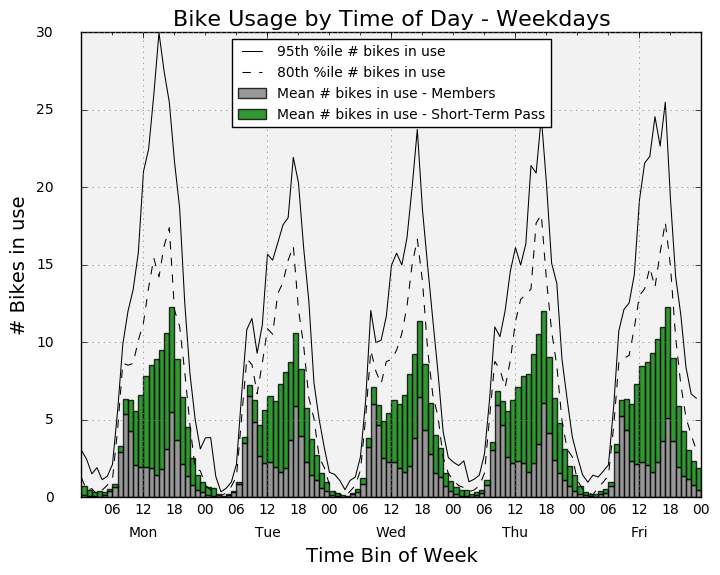

In [46]:
# Create a Figure and Axes object
#--------------------------------

fig2 = plt.figure()
ax2 = fig2.add_subplot(1,1,1)

# Create a list to use as the X-axis values
#-------------------------------------------

timestamps = pd.date_range('01/05/2015', periods=120, freq='60Min').tolist()

major_tick_locations = pd.date_range('01/05/2015 12:00:00', periods=5, freq='24H').tolist()
minor_tick_locations = pd.date_range('01/05/2015 06:00:00', periods=20, freq='6H').tolist()


# Styling of bars, lines, plot area
#-----------------------------------

# Style the bars for mean occupancy
bar_color_member = 'grey'
bar_color_shortterm = 'green'
bar_opacity = 0.8

# Style the line for the occupancy percentile
pctile95_line_style = '-'
pctile80_line_style = '--'
pctile_color = 'black'
pctile_line_width = 0.75

# Set the background color of the plot. Argument is a string float in
# (0,1) representing greyscale (0=black, 1=white)
ax2.patch.set_facecolor('0.95')

# Can also use color names or hex color codes
# ax2.patch.set_facecolor('yellow')
# ax2.patch.set_facecolor('#FFFFAD')


# Add data to the plot
#--------------------------

label_member = 'Mean # bikes in use - Members'
label_shortterm = 'Mean # bikes in use - Short-Term Pass'

# Mean occupancy as bars
ax2.bar(timestamps, wkday_mean_member_occ, color=bar_color_member, alpha=bar_opacity, label=label_member, width=1/24)
ax2.bar(timestamps, wkday_mean_shortterm_occ, bottom=wkday_mean_member_occ, color=bar_color_shortterm, 
        alpha=bar_opacity, label=label_shortterm, width=1/24)

# Percentiles as lines
ax2.plot(timestamps, wkday_p95_total_occ, linestyle=pctile95_line_style, linewidth=pctile_line_width, color=pctile_color, \
         label='95th %ile # bikes in use')

ax2.plot(timestamps, wkday_p80_total_occ, linestyle=pctile80_line_style, linewidth=pctile_line_width, color=pctile_color, \
         label='80th %ile # bikes in use')


# Create formatter variables
dayofweek_formatter = DateFormatter('%a')
qtrday_formatter = DateFormatter('%H')

# Set the tick locations for the axes object
ax2.set_xticks(major_tick_locations)
ax2.set_xticks(minor_tick_locations, minor=True)

# Format the tick labels
ax2.xaxis.set_major_formatter(dayofweek_formatter)
ax2.xaxis.set_minor_formatter(qtrday_formatter)

# Slide the major tick labels underneath the default location by 20 points
ax2.tick_params(which='major', pad=20)

# Add other chart elements
#-------------------------

# Set plot and axis titles
ax2.set_title('Bike Usage by Time of Day - Weekdays', fontsize=16)
ax2.set_xlabel('Time Bin of Week', fontsize=14)
ax2.set_ylabel('# Bikes in use', fontsize=14)

# Gridlines
ax2.grid(True, color='grey')

# Legend
leg = ax2.legend(loc='best', frameon=True, fontsize=10)
leg.get_frame().set_facecolor('white')

# Plot size
fig2.set_size_inches(8,6)

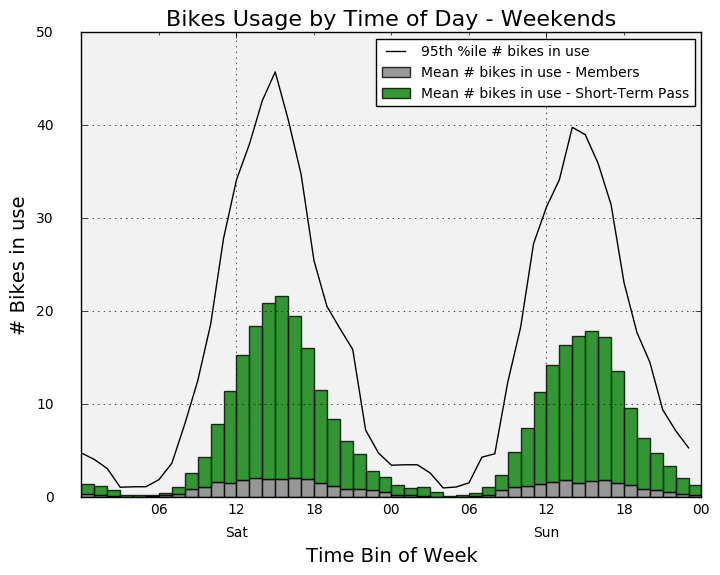

In [47]:
# Create a Figure and Axes object
#--------------------------------

fig3 = plt.figure()
ax3 = fig3.add_subplot(1,1,1)

# Create a list to use as the X-axis values
#-------------------------------------------

timestamps = pd.date_range('01/03/2015', periods=48, freq='60Min').tolist()

major_tick_locations = pd.date_range('01/03/2015 12:00:00', periods=2, freq='24H').tolist()
minor_tick_locations = pd.date_range('01/03/2015 06:00:00', periods=8, freq='6H').tolist()


# Styling of bars, lines, plot area
#-----------------------------------

# Style the bars for mean occupancy
bar_color_member = 'grey'
bar_color_shortterm = 'green'
bar_opacity = 0.8

# Style the line for the occupancy percentile
pctile_line_style = '-'
pctile_color = 'black'
pctile_line_width = 1

# Set the background color of the plot. Argument is a string float in
# (0,1) representing greyscale (0=black, 1=white)
ax3.patch.set_facecolor('0.95')

# Can also use color names or hex color codes
# ax2.patch.set_facecolor('yellow')
# ax2.patch.set_facecolor('#FFFFAD')


# Add data to the plot
#--------------------------

label_member = 'Mean # bikes in use - Members'
label_shortterm = 'Mean # bikes in use - Short-Term Pass'

# Mean occupancy as bars
ax3.bar(timestamps, wkend_mean_member_occ, color=bar_color_member, alpha=bar_opacity, label=label_member, width=1/24)
ax3.bar(timestamps, wkend_mean_shortterm_occ, bottom=wkend_mean_member_occ, color=bar_color_shortterm, 
        alpha=bar_opacity, label=label_shortterm, width=1/24)

# Some percentile aas a line
ax3.plot(timestamps, wkend_p95_total_occ, linestyle=pctile_line_style, linewidth=pctile_line_width, color=pctile_color, \
         label='95th %ile # bikes in use')


# Create formatter variables
dayofweek_formatter = DateFormatter('%a')
qtrday_formatter = DateFormatter('%H')

# Set the tick locations for the axes object

ax3.set_xticks(major_tick_locations)
ax3.set_xticks(minor_tick_locations, minor=True)

# Format the tick labels
ax3.xaxis.set_major_formatter(dayofweek_formatter)
ax3.xaxis.set_minor_formatter(qtrday_formatter)

# Slide the major tick labels underneath the default location by 20 points
ax3.tick_params(which='major', pad=20)

# Add other chart elements
#-------------------------

# Set plot and axis titles

ax3.set_title('Bikes Usage by Time of Day - Weekends', fontsize=16)
ax3.set_xlabel('Time Bin of Week', fontsize=14)
ax3.set_ylabel('# Bikes in use', fontsize=14)

# Gridlines
ax3.grid(True, color='k')

# Legend
leg = ax3.legend(loc='upper right', frameon=True, fontsize=10)
leg.get_frame().set_facecolor('white')

# Plot size
fig3.set_size_inches(8,6)

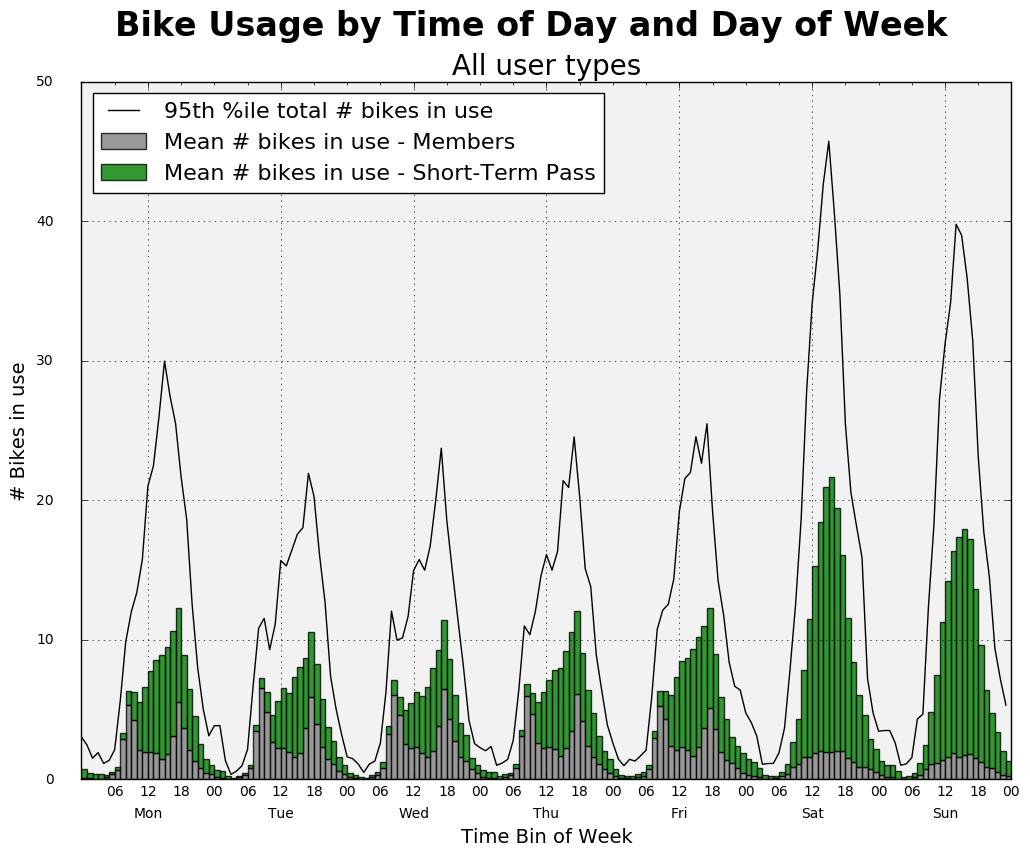

In [48]:
# Create a Figure and Axes object
#--------------------------------

fig4 = plt.figure()
ax4 = fig4.add_subplot(1,1,1)

# Create a list to use as the X-axis values
#-------------------------------------------

timestamps = pd.date_range('01/05/2015', periods=168, freq='60Min').tolist()

major_tick_locations = pd.date_range('01/05/2015 12:00:00', periods=7, freq='24H').tolist()
minor_tick_locations = pd.date_range('01/05/2015 06:00:00', periods=28, freq='6H').tolist()

# Specify the mean occupancy and percentile values
#-----------------------------------------------------------
mean_shortterm_occ = occ_df.loc['Short-Term Pass Holder']['mean']
mean_member_occ = occ_df.loc['Member']['mean']
p95_total_occ = occ_df.loc['Total']['p95']

# Styling of bars, lines, plot area
#-----------------------------------

# Style the bars for mean occupancy
bar_color_member = 'grey'
bar_color_shortterm = 'green'
bar_opacity = 0.8

# Style the line for the occupancy percentile
pctile_line_style = '-'
pctile_color = 'black'
pctile_line_width = 1

# Set the background color of the plot. Argument is a string float in
# (0,1) representing greyscale (0=black, 1=white)
ax4.patch.set_facecolor('0.95')

# Can also use color names or hex color codes
# ax2.patch.set_facecolor('yellow')
# ax2.patch.set_facecolor('#FFFFAD')


# Add data to the plot
#--------------------------

label_member = 'Mean # bikes in use - Members'
label_shortterm = 'Mean # bikes in use - Short-Term Pass'

# Mean occupancy as bars
ax4.bar(timestamps, mean_member_occ, color=bar_color_member, alpha=bar_opacity, label=label_member, width=1/24)
ax4.bar(timestamps, mean_shortterm_occ, bottom=mean_member_occ, color=bar_color_shortterm, 
        alpha=bar_opacity, label=label_shortterm, width=1/24)


# Some percentile aas a line
ax4.plot(timestamps, p95_total_occ, linestyle=pctile_line_style, linewidth=pctile_line_width, color=pctile_color, \
         label='95th %ile total # bikes in use')


# Create formatter variables
dayofweek_formatter = DateFormatter('%a')
qtrday_formatter = DateFormatter('%H')

# Set the tick locations for the axes object

ax4.set_xticks(major_tick_locations)
ax4.set_xticks(minor_tick_locations, minor=True)

# Format the tick labels
ax4.xaxis.set_major_formatter(dayofweek_formatter)
ax4.xaxis.set_minor_formatter(qtrday_formatter)

# Slide the major tick labels underneath the default location by 20 points
ax4.tick_params(which='major', pad=20)

# Add other chart elements
#-------------------------

# Set plot and axis titles
fig4.suptitle('Bike Usage by Time of Day and Day of Week', fontsize=24, fontweight='bold')
ax4.set_title('All user types', fontsize=20)
ax4.set_xlabel('Time Bin of Week', fontsize=14)
ax4.set_ylabel('# Bikes in use', fontsize=14)

# Gridlines
ax4.grid(True, color='k')

# Legend
leg = ax4.legend(loc='best', frameon=True, fontsize=16)
leg.get_frame().set_facecolor('white')

# Plot size
fig4.set_size_inches(12,9)

Lots more we can do, but this should illustrate the basic idea.